# Dimensionality Reduction


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

## The UCI wine dataset
These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.

In [2]:
from sklearn.datasets import load_wine

In [3]:
#Let's import the data from sklearn
from sklearn.datasets import load_wine
wine=load_wine()

#Conver to pandas dataframe
df = pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

#Check data with info function
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [4]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


## Lets see if any features are highly correlated

In [5]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

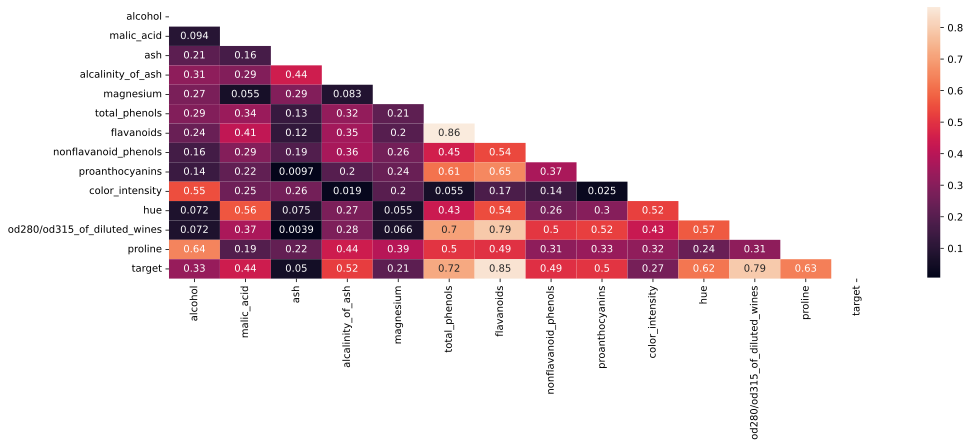

In [6]:
#make the heatmap fit on the screen
plt.figure(figsize=(16, 5))

# generate the correlation matrix (abs converts to absolute value, this way we only look for 1 color range)
corr = df.corr().abs()

# Generate mask for the upper triangle (see https://seaborn.pydata.org/examples/many_pairwise_correlations.html)
# the matrix is symmetric, the diagonal (all 1's) and upper triangle are visual noise, use this to mask both out
mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)    #k=-1 means get rid of the diagonal

corr = corr.where(cond=mask)

sns.heatmap(corr, annot=True);

There seems to be some correlation around total_phenols and favanoids, lets see which columns are of interest for various correlations

In [7]:
def get_correlated_columns(df,correlation_threshold ):
    '''
    df: a dataframe that contains a correlation matrix
    correlation_threshold: select all rows and columns that have a correlation >= to this value
    return: list of tuples of form [ (col,row),...]
    '''
    correlated=[]
    for col in df.columns:
        for i,val in enumerate(df.loc[col]):
            if( val>= correlation_threshold):
                correlated.append((col,df.loc[col].index[i]))
    return correlated

#select all columns that meet or exceed this threshold
#thresholds are usually >.95 (95%) otherwise you risk losing some signal
#used .87 just to demo what these do
correlation_threshold = .82
correlated = get_correlated_columns(corr, correlation_threshold)
print(f'Here is a list of the correlated tuples, consider dropping 1{correlated}')

Here is a list of the correlated tuples, consider dropping 1[('flavanoids', 'total_phenols'), ('target', 'flavanoids')]


In [8]:
# use a list comprehension to expand the list into tuples and then expand each tuple into a value
#then convert to a set to get rid of overlaps
cols = list(set([item for tup in correlated for item in tup]))
cols

['total_phenols', 'flavanoids', 'target']

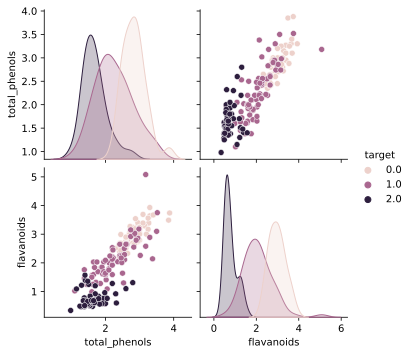

In [9]:
#lets see what they look like   
df1=df[cols]
# sns.pairplot(df1)
sns.pairplot(df1, hue='target')

Flavanoids and total phenals are definitely correlated, but probably not enough to get rid of either column since threshold is only 87%

## PCA for feature (dimensionality) reduction

### first scale the data since PCA requires standardization

In [10]:
import utils as ut
from sklearn.preprocessing import StandardScaler

<mark>Lets remove the target, it's the type of wine, we will use it later when plotting

In [11]:
df_target=df.target
df.drop('target', axis=1, inplace=True)

In [12]:
df1=df.copy()
df2=df.copy()

In [13]:
%%time
df1 = ut.scale(df, list(df1.columns), StandardScaler())

CPU times: user 3.83 ms, sys: 244 µs, total: 4.07 ms
Wall time: 3.54 ms


In [14]:
%%time
df2= pd.DataFrame(StandardScaler().fit_transform(df2), columns=df2.columns)

CPU times: user 4.01 ms, sys: 0 ns, total: 4.01 ms
Wall time: 3.62 ms


Sklearn standardscaler is twice as fast on this tiny dataset than the scale function in utilities<br>
In anycase we now have a dataframe to work with, lets get rid of the extra (df2) to get in the habbit of conserving memory

In [15]:
del df2
import gc 
gc.collect()  #ask garbage collector to reclaim df2 memory

12235

### Now PCA

In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=.95, whiten=True)

In [18]:
features_pca=pd.DataFrame(pca.fit_transform(df1))
print(f'Orig #features={df.shape[1]}, number features containing 95% of variance={features_pca.shape[1]}')

Orig #features=13, number features containing 95% of variance=10


In [19]:
features_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,1.524651,-0.910909,-0.137438,-0.224304,0.748177,-0.278702,0.801211,0.110032,1.190079,2.032503
1,1.015651,0.210390,-1.680425,-0.303077,-0.278152,-1.154147,0.072240,1.730427,-0.573008,0.317931
2,1.156900,-0.650717,0.814995,0.754058,-0.271004,0.683779,0.569857,-0.581444,-2.185255,0.225677
3,1.727056,-1.739432,-0.146106,0.590827,-0.336650,0.142452,-0.514957,1.087148,0.097487,0.476619
4,0.463777,-0.548914,1.680616,-0.426246,0.322201,-0.506065,0.596548,0.703884,0.606353,-0.156011


features_pca are the new features that define our wineset, a dataframe with the same number of rows but <mark> fewer columns

### Lets see what each Principle component does for us

In [20]:
#lets see how important each of those Principal Component's are
pca_ev=pca.explained_variance_ratio_
pca_ev

array([0.36198848, 0.1920749 , 0.11123631, 0.0706903 , 0.06563294,
       0.04935823, 0.04238679, 0.02680749, 0.02222153, 0.01930019])

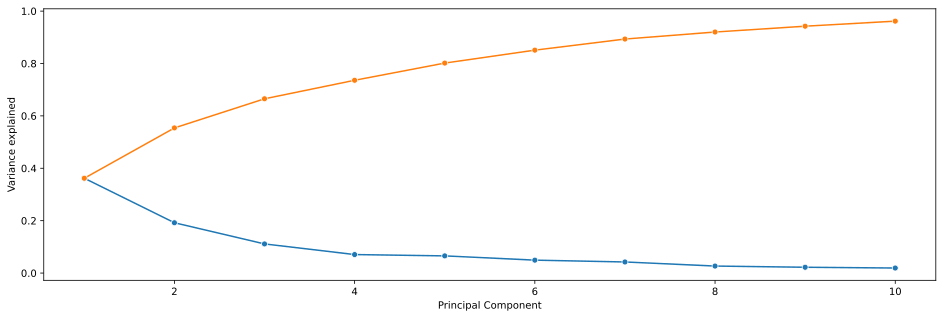

In [21]:
fig, ax1 = plt.subplots(figsize=(16, 5))
p= sns.lineplot(y=pca_ev,x=range(1,11), marker='o', ax=ax1)
sns.lineplot(y=np.cumsum(pca.explained_variance_ratio_),x=range(1,11), marker='o', ax=ax1);
p.set_xlabel("Principal Component");
p.set_ylabel("Variance explained");

### Add the target back for plotting

In [22]:
features_pca = pd.concat([features_pca,df_target ], axis=1)

### How much of the variance explained is in the first 2 principle components, 

In [23]:
print(f'The total variance explained by the first 2 Principle Components is {pca_ev[0]+pca_ev[1]}')

The total variance explained by the first 2 Principle Components is 0.5540633835693534


### Now plot using first 2 principle components

In [24]:
# features_pca.head()
#the column names are numbers, not strings, so the x and y values below are numbers as well
features_pca.head()

,0,1,2,3,4,5,6,7,8,9,target
0,1.524651,-0.910909,-0.137438,-0.224304,0.748177,-0.278702,0.801211,0.110032,1.190079,2.032503,0.0
1,1.015651,0.210390,-1.680425,-0.303077,-0.278152,-1.154147,0.072240,1.730427,-0.573008,0.317931,0.0
2,1.156900,-0.650717,0.814995,0.754058,-0.271004,0.683779,0.569857,-0.581444,-2.185255,0.225677,0.0
3,1.727056,-1.739432,-0.146106,0.590827,-0.336650,0.142452,-0.514957,1.087148,0.097487,0.476619,0.0
4,0.463777,-0.548914,1.680616,-0.426246,0.322201,-0.506065,0.596548,0.703884,0.606353,-0.156011,0.0


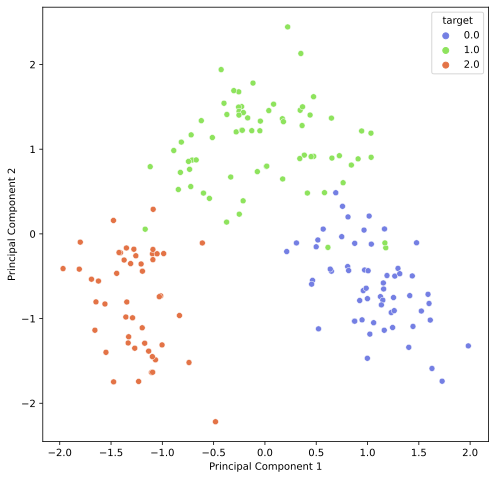

In [25]:
colors = ['#747FE3', '#8EE35D', '#E37346']
fig, ax1 = plt.subplots(figsize=(8, 8))
p= sns.scatterplot(data=features_pca, x=0, y=1, hue='target', palette=colors)

p.set_xlabel("Principal Component 1");
p.set_ylabel("Principal Component 2");

### The first 2 principle components seem to describe the data nicely

## Homework:  Visualize with t-SNE, a useful algorithm for projecting high dimensional data onto a 2 or 3 dimensonal spaces works
<mark>CAUTION: t-SNE is used just for visualization, not for dimensionality reduction since it does not preserve distance info.</mark>
See <a href="https://distill.pub/2016/misread-tsne/">How to Use t-SNE Effectively</a> for an explanation of t-SNE and it's pitfalls.
 


## BONUS:  Lets see how UMAP, another dimensionality reduction algorithm performs

In [26]:
# run this once
!conda install -c conda-forge umap-learn -y

Solving environment: done

## Package Plan ##

  environment location: /home/keith/anaconda3/envs/data301

  added / updated specs:
    - umap-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pynndescent-0.5.6          |     pyh6c4a22f_0          45 KB  conda-forge
    umap-learn-0.5.2           |   py39hf3d152e_1         131 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         177 KB

The following NEW packages will be INSTALLED:

  pynndescent        conda-forge/noarch::pynndescent-0.5.6-pyh6c4a22f_0
  umap-learn         conda-forge/linux-64::umap-learn-0.5.2-py39hf3d152e_1

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2021.10.26~ --> conda-forge::ca-certificates-2021.10.8-ha878542_0
  certifi            pkgs/main::cert

In [27]:
import umap

In [28]:
reducer = umap.UMAP()

In [29]:
df2=df.copy()

In [32]:
embedding = reducer.fit_transform(df2)
embedding.shape

(178, 2)

In [38]:
#add target back
# embeddings = pd.concat([features_pca,df_target ], axis=1)


pandas.core.series.Series

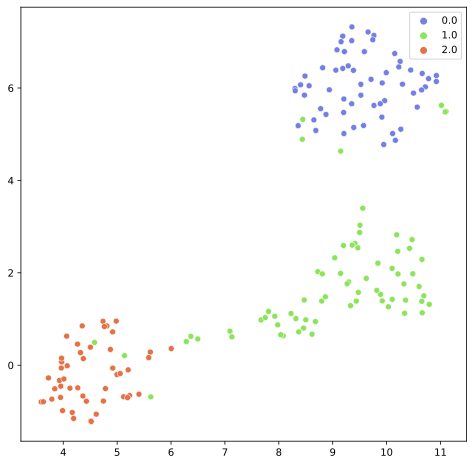

In [41]:
fig, ax1 = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df_target.to_numpy(), palette=colors );